In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import graphviz
from graphviz import Digraph
#https://stackoverflow.com/questions/52472611/how-do-i-make-sure-the-graphviz-executables-are-on-my-systems-path
os.environ["PATH"] += os.pathsep + r'C:/Program Files/Graphviz/bin/'
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

In [5]:
h = 0.001
x = -3.0
(f(x + h) - f(x))/h

-21.996999999998934

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [7]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('slope',(d2 - d1)/h)

slope -3.000000000010772


In [8]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('slope',(d2 - d1)/h)

slope 2.0000000000042206


In [9]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('slope',(d2 - d1)/h)

slope 0.9999999999976694


Building the Value Object

In [10]:
class Value:
    def __init__(self,data):
        self.data = data
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data)
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10)
a + b
a * b
a*b + c

Value(data=4.0)

The above implementation cannot maintain a computation graph. Hence its required that each node/value keep track of which values hold data and connected to it

In [11]:
class Value:
    #when we create a single values Value object, we dont
    #pass in any children, however when we do an operation
    #we pass in the associated objects to be held as children
    def __init__(self,data,_children = ()):
        #the input will be a tuple of children
        #but the data will be held as a Set
        #done for efficiency
        self.data = data
        self._prev = set(_children)
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data,_children = (self,other))
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data,_children = (self,other))
        return out
    
a = Value(2.0)
b = Value(-3.0)
c = Value(10)
a + b
a * b
#a*b results in a Value object with _prev
#The object from a*b is fed into the addition method
#and the final object will also have a _prev
d = a*b + c
d

Value(data=4.0)

In [12]:
d._prev

{Value(data=-6.0), Value(data=10)}

Currently we still dont know which operation created the d value

In [36]:
class Value:
    #when we create a single values Value object, we dont
    #pass in any children, however when we do an operation
    #we pass in the associated objects to be held as children
    def __init__(self,data,_children = (),_op = '',label = ''):
        #the input will be a tuple of children
        #but the data will be held as a Set
        #done for efficiency
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data,_children = (self,other),_op = '+')
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data,_children = (self,other),_op = '*')
        return out

The above expressions are simple. But they get large very fast. Hence we need a way to visualize these functions. 

In [53]:
def trace(root):
    nodes,edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for i in v._prev:
            edges.add((v,i,v._op))
            build(i)
    build(root)
    return nodes,edges

def obtain_label(edge):
    key_names = {'child_name':None,
                 'parent_name':None,
                 'operation':None}
    child = edge[1]
    parent = edge[0]
    op = edge[2]
    if child.label == '':
        key_names['child_name'] = f"{child._op} \n Value = {child.data}"
    else:
        key_names['child_name'] = child.label
    if parent.label == '':
        key_names['parent_name'] = f"{parent._op} \n Value = {parent.data}"
    else:
        key_names['parent_name'] = parent.label
    key_names['operation'] = op
    return key_names




def build_graph(root):
    nodes,edges = trace(root)
    dot = graphviz.Digraph('computation_graph',graph_attr={'rankdir' : 'LR'})
    # id_node_dict = {}
    for node in nodes:
        uid = str(id(node))
        dot.node(uid,label = f"{node.label} | Value = {np.round(node.data,4)} | Grad = {np.round(node.grad,4)}",shape = 'record')
        #if node._op is not empty that means the node is a result of an operation. So we connect the operation to the resultant node 
        if node._op != '':
            dot.node(uid + f"_{node._op}",label = f"{node._op}")
            dot.edge(uid + f"_{node._op}",uid)
        # else:
        #     #this means its a result of an operation
        #     uid = str(id(node))
        #     dot.node(uid,label = f"{node.label} | \n Value = {node.data}",shape = 'record')
    for edge in edges:
        # required_data = obtain_label(edge)
        # dot.edge(required_data['child_name'],required_data['parent_name'])
        dot.edge(str(id(edge[1])),str(id(edge[0])) + f"_{edge[2]}")
    return dot

Create a Variable inside the value class that maintains the derivative of the loss function with respect to that value

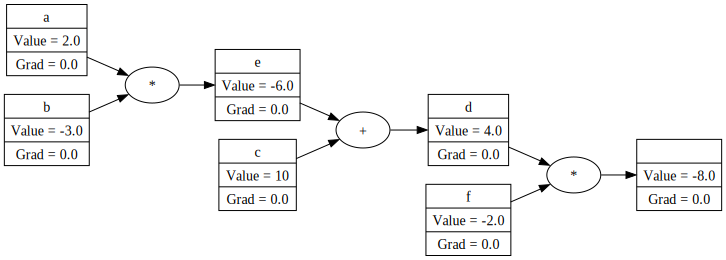

In [40]:
class Value:
    #when we create a single values Value object, we dont
    #pass in any children, however when we do an operation
    #we pass in the associated objects to be held as children
    def __init__(self,data,_children = (),_op = '',label = ''):
        #the input will be a tuple of children
        #but the data will be held as a Set
        #done for efficiency
        self.data = data
        #at initialization we assume that the value has no impact on loss
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data,_children = (self,other),_op = '+')
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data,_children = (self,other),_op = '*')
        return out
    
a = Value(2.0,label = 'a')
b = Value(-3.0,label = 'b')
c = Value(10,label = 'c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0,label = 'f')
L = d * f
L
build_graph(L)

L = d*f

dL/dd = f


In [45]:
L.grad = 1
d.grad = f.data
f.grad = d.data
c.grad = d.grad
e.grad = d.grad
a.grad = e.grad*b.data
b.grad = e.grad*a.data

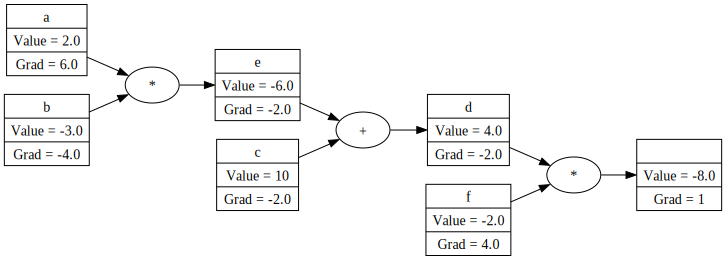

In [46]:
build_graph(L)

If we change **c** a bit how does it impact **L through d**

dd / dc = 1

dL/dc = dL/dd * dd/dc

The local node, a + node or * node has no understanding or knowledge of the other nodes. It has only knowledge of taking in 2 inputs and producing 1 output by doing a simple operation on it.

Hence it can know the local influence of the input on the output (i.e. the derivative)

"+" node:

As the derivative of a "+" node is only 1, a "+" node is only routing the derivative from upstream. **The "+" node simply distributes the derivative to all the leaf nodes**

It is always upstream gradient * local gradient

<h3> Backprop through a neuron </h3>

In [49]:
class Value:
    #when we create a single values Value object, we dont
    #pass in any children, however when we do an operation
    #we pass in the associated objects to be held as children
    def __init__(self,data,_children = (),_op = '',label = ''):
        #the input will be a tuple of children
        #but the data will be held as a Set
        #done for efficiency
        self.data = data
        #at initialization we assume that the value has no impact on loss
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data,_children = (self,other),_op = '+')
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data,_children = (self,other),_op = '*')
        return out
    #we dont need to have the most atomic pieces of a function
    #we can have arbitary points of abstraction
    #only thing that matters is how to differentiate
    #create the local derivative
    def tanh(self):
        num = np.exp(self.data * 2) - 1
        den = np.exp(self.data * 2) + 1
        out = Value(num/den,_children = (self,),_op='tanh')
        return out

In [61]:
#input x1,x2
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0,label = 'x2')
#weights w1,w2
w1 = Value(-3.0,label = 'w1')
w2 = Value(1.0,label = 'w2')
#bias of neuron 
b = Value(6.8813735870195432,label = 'b')

x1w1 = x1*w1;x1w1.label = 'x1w1'
x2w2 = x2*w2;x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2;x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b;n.label = 'n'
#need to implement activation
o = n.tanh()
o.label = 'o'
o

Value(data=0.7071067811865476)

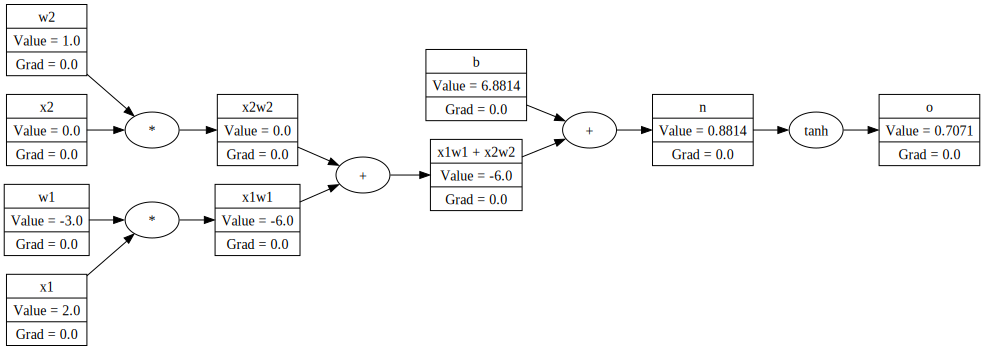

In [62]:
build_graph(o)

In [72]:
o.grad = 1
n.grad = 1 - (o.data**2)
b.grad = n.grad
x1w1x2w2.grad = n.grad
x2w2.grad = x1w1x2w2.grad
x1w1.grad = x1w1x2w2.grad
w2.grad = x2w2.grad*x2.data
x2.grad = x2w2.grad*w2.data
w1.grad = x1w1.grad*x1.data
x1.grad = x1w1.grad*w1.data

Note that the gradient, says that if the output were to increase by a small nudge in the value, the output changes + or - depending on the sign of the gradient.

Also note that x2 is zero and w2 grad is 0. This means that if we nudge w2, it wont cause an effect on x2w2 because x2 is zero.

In order to increase the value of **o**, we should increase the value of w1, decrease the value of x1

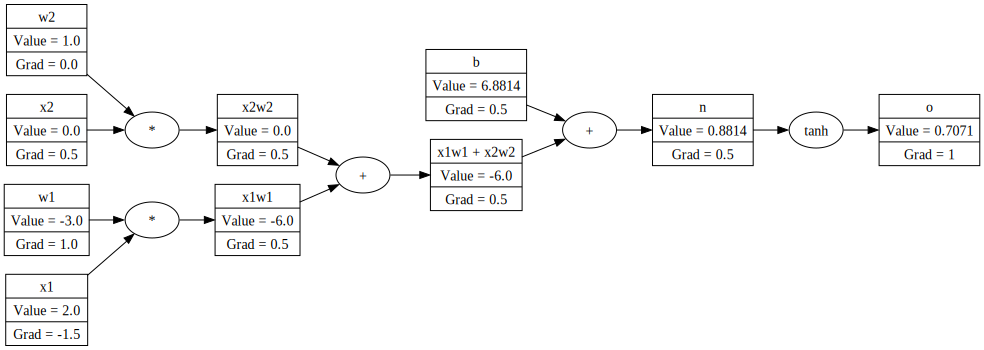

In [73]:
build_graph(o)

<h3>Doing backwards pass automatically </h3>

In [68]:
np.tanh(n.data)*np.tanh(n.data)

0.5000000000000001